# ダブルクロスバリデーション
LightGBMのダブルクロスバリデーションの学習過程を図示する。
`test_loss`,`refit_test_loss`,`valid_loss`,`train_loss`について図示する.
validation時のハイパーパラメータ調整ではベイズ最適化を使用する。

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import optuna
import random

import lightgbm as lgb

import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import LeaveOneGroupOut
from scipy.stats import pearsonr
# from joblib import Parallel, delayed

import warnings
warnings.simplefilter('ignore')

In [2]:
def my_score(true, pred):
    r, p_value = pearsonr(true, pred)
    if np.isnan(r):
        r = 0
    return 1-r

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame({
                          'score': my_score(true, pred),
                          'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

def my_metric(preds: np.ndarray, data: lgb.Dataset):
    """Calculate Binary Accuracy"""
    # 正解ラベル
    y_true = data.get_label()
    # score = my_score(y_true,preds)
    score = r2_score(y_true,preds)

    # # eval_name, eval_result, is_higher_better
    return 'my_score', score, True

In [4]:
print("Loading data...",end='')
# load or create your dataset
X_all = []
Y_all = []
sub_list = []
sub_max = 4

X, Y, coef = make_regression(random_state=42, 
                    n_samples=250*sub_max, 
                    n_features=1000,
                    n_informative=2,
                    noise=10.0,
                    bias=-0.0,
                    coef=True)

sub_list = np.arange(sub_max) + 1

X_all = X
Y_all = Y
random.seed(42)
sub_list = np.array(random.choices(sub_list,k=len(Y_all)))
print('Completed!')

Loading data...Completed!


In [5]:
outer_cv = LeaveOneGroupOut()
# pruner = optuna.pruners.HyperbandPruner()
for i, (train_index, test_index) in enumerate(outer_cv.split(X_all,Y_all,sub_list)):
    y_train_outer = Y_all[train_index]
    y_test_outer = Y_all[test_index]
    X_train_outer = X_all[train_index]
    X_test_outer = X_all[test_index]
    sub_train_outer = sub_list[train_index]
    sub_test_outer = sub_list[test_index]


    inner_cv = LeaveOneGroupOut()

[I 2025-04-24 18:07:02,078] A new study created in memory with name: no-name-f7fbee1b-18c8-439b-958e-d2b9c619a2d8


feature_fraction1
num_leaves
bagging
feature_fraction2
l1l2
min_child_samples
Number of finished trials: 50
Best trial: {'min_child_samples': 2}


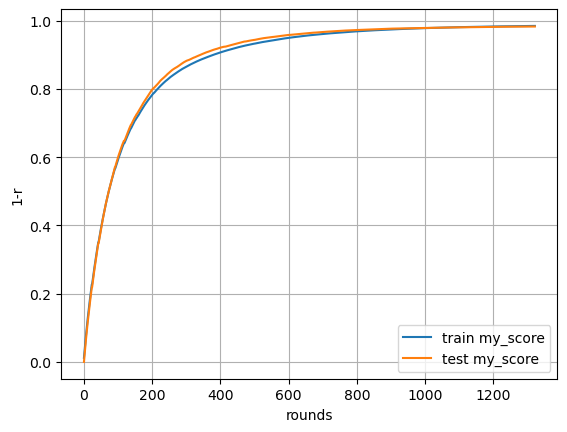

           score        R2       MAE         MSE       RMSE
scores  0.008694  0.982032  9.962358  149.323423  12.219796


In [6]:
setting_param = {
    'objective': 'regression',
    'metric': 'None',
    "verbose": -1,
    'seed': 0,
    "boosting_type": "gbdt",
    'tree_learner':'feature', # feature_parallel
    'num_threads': -1,
    'num_iterations': 10000,
    'learning_rate': 0.01,
    'early_stopping_round': 100,
    'early_stopping_min_delta': 0.001,
    'device_type': "gpu",
    'gpu_platform_id': 1,
    'gpu_device_id': 0,
}

tune_param_list = [
    'feature_fraction1',
    'num_leaves',
    'bagging',
    'feature_fraction2',
    'l1l2',
    'min_child_samples'
]
for now_tune_param in tune_param_list:
    print(now_tune_param)
    def objective(trial):
        if now_tune_param == 'feature_fraction1':
            tune_param = {'feature_fraction': trial.suggest_loguniform('feature_fraction', 10**-(len(str(X.shape[1]))), 1.0)}
        elif now_tune_param == 'num_leaves':
            tune_param = {'num_leaves': trial.suggest_int('num_leaves', 2, 256)}
        elif now_tune_param == 'bagging':
            tune_param = {'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.001, 1.0),'bagging_freq': trial.suggest_int('bagging_freq', 1, 10)}
        elif now_tune_param == 'feature_fraction2':
            tune_param = {'feature_fraction': trial.suggest_loguniform('feature_fraction', max(10**-(len(str(X.shape[1]))),setting_param['feature_fraction']-0.1), min(setting_param['feature_fraction']+0.1,1.0))}
        elif now_tune_param == 'l1l2':
            tune_param = {'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)}
        elif now_tune_param == 'min_child_samples':
            tune_param = {'min_child_samples': trial.suggest_int('min_child_samples', 2, 100)}
        else:
            print(f'Not defined \"{now_tune_param}\"')
            stop()

        param = setting_param | tune_param
        pred_inner_list = []
        true_inner_list = []

        for j, (inner_index, valid_index) in enumerate(inner_cv.split(X_train_outer,y_train_outer,sub_train_outer)):
            y_train_inner = y_train_outer[inner_index]
            y_test_inner = y_train_outer[valid_index]
            X_train_inner = X_train_outer[inner_index]
            X_test_inner = X_train_outer[valid_index]
        
            dtrain = lgb.Dataset(X_train_inner, label=y_train_inner)
            deval = lgb.Dataset(X_test_inner,label=y_test_inner)
            
            evals_result = {}
            gbm = lgb.train(param, dtrain,  valid_sets=[dtrain, deval], valid_names=['train', 'test'],callbacks=[lgb.record_evaluation(evals_result)],feval=my_metric)
            preds = gbm.predict(X_test_inner)
            pred_inner_list = np.append(pred_inner_list,preds)
            true_inner_list = np.append(true_inner_list, y_test_inner)
            trial.set_user_attr('lightGBM_iter_{}'.format(j),len(evals_result['train']['my_score']))

            # train の評価
            train_pred = gbm.predict(X_train_inner)
            train_score = my_score(true=y_train_inner,pred=train_pred)
            trial.set_user_attr('train_score_{}'.format(j), train_score)

            # validの評価
            valid_score = my_score(true=y_test_inner,pred=preds)
            trial.set_user_attr('valid_score_{}'.format(j), valid_score)

            # testの評価
            test_pred = gbm.predict(X_test_outer)
            test_score = my_score(true=y_test_outer,pred=test_pred)
            trial.set_user_attr('test_score_{}'.format(j), test_score)

            # 現時点での中間評価
            # print(true_inner_list.shape)
            all_valid_score = my_score(true=true_inner_list,pred=pred_inner_list)
            trial.report(all_valid_score, j)
            if trial.should_prune():
                raise optuna.TrialPruned()


        # 全体でのValid評価
        # all_valid_score = my_score(true=np.array(true_inner_list).reshape(-1),pred=np.array(pred_inner_list).reshape(-1))
        trial.set_user_attr('all_valid_score', all_valid_score)

        # refit
        rtrain = lgb.Dataset(X_train_outer, label=y_train_outer)
        reval = lgb.Dataset(X_test_outer, label=y_test_outer)
        evals_result = {}
        gbm = lgb.train(params=param,train_set=rtrain, valid_sets=[rtrain, reval], valid_names=['train', 'test'],callbacks=[lgb.record_evaluation(evals_result)],feval=my_metric)
        trial.set_user_attr('lightGBM_iter_refit',len(evals_result['train']['my_score']))

        # train の評価
        train_pred = gbm.predict(X_train_outer)
        train_score = my_score(true=y_train_outer,pred=train_pred)
        trial.set_user_attr('retrain_score'.format(j), train_score)
        # testの評価
        test_pred = gbm.predict(X_test_outer)
        test_score = my_score(true=y_test_outer,pred=test_pred)
        trial.set_user_attr('retest_score'.format(j), test_score)

        return all_valid_score
    
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction='minimize')
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective ,n_trials=50, n_jobs=-1)
    study_df = study.trials_dataframe(multi_index=True)
    study_df.to_csv('train_{}_log_{:02d}.csv'.format(now_tune_param,i))
    for bps in study.best_trial.params:
        setting_param[bps] = study.best_trial.params[bps]
# Parallel(n_jobs=4)(delayed(study.optimize)(objective, n_trials=10) for _ in range(4))
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

otrain = lgb.Dataset(X_train_outer, label=y_train_outer)
oeval = lgb.Dataset(X_test_outer, label=y_test_outer)

param = setting_param | study.best_params
evals_result = {}
gbm = lgb.train(params=param,train_set=otrain,valid_sets=[otrain, oeval], valid_names=['train', 'test'],callbacks=[lgb.record_evaluation(evals_result)],feval=my_metric)

train_metric = evals_result['train']['my_score']
eval_metric = evals_result['test']['my_score']

plt.plot(train_metric, label='train my_score')
plt.plot(eval_metric, label='test my_score')
plt.grid()
plt.legend()
# plt.ylim(0, 1.1)

plt.xlabel('rounds')
plt.ylabel('1-r')
plt.show()

preds = gbm.predict(X_test_outer)
scores = calculate_scores(y_test_outer,preds)
print(scores)

gbm.save_model('{:02d}_best_model.txt'.format(i))

メモ：  
iter=10  
- cpu_method: 29m 34.9s
- gpu_methond: 30m 19.6s

In [7]:
study_df = study.trials_dataframe(multi_index=True)
study_df

# fig = plt.Figure(figsize=(10))

study_df[['user_attrs','state']]

user_attrs                                                  \
   all_valid_score lightGBM_iter_0 lightGBM_iter_1 lightGBM_iter_2   
0         0.051163             894             792           869.0   
1         0.028802             993            1005           966.0   
2         0.011707            1384            1362          1247.0   
3         0.056494             877             796           860.0   
4         0.058072             988             784           897.0   
5         0.060752             923             796           761.0   
6         0.011687            1418            1321          1305.0   
7         0.026521            1135            1002           964.0   
8         0.063710             911             792           838.0   
9         0.041634             833             897           961.0   
10        0.016784            1284            1217          1064.0   
11        0.051867             912             856           870.0   
12        0.026521            1135            1002           964.0   
13        0.018569            1202            1181          1066.0   
14        0.012901            1285            1316          1185.0   
15        0.057706             924             798           854.0   
16        0.031096            1134            1063           964.0   
17        0.057159             991             785           862.0   
18        0.049145             825             885           865.0   
19        0.064705             988             754           785.0   
20        0.049697             835             789           928.0   
21        0.010623            1412            1351          1446.0   
22        0.042245             830             900           899.0   
23        0.058072             988             784           897.0   
24        0.027270            1086            1000           969.0   
25        0.032921             987             887           965.0   
26        0.018259            1142            1154          1038.0   
27        0.059109             910             720           769.0   
28        0.043635             875             951           896.0   
29        0.012038            1379            1293          1205.0   
30        0.055740             830             785           864.0   
31        0.011973            1369            1358          1230.0   
32        0.012901            1285            1316          1185.0   
33        0.024927            1050            1064          1037.0   
34        0.024482            1132            1050           990.0   
35             NaN             866             903             NaN   
36        0.025601            1103            1002           964.0   
37        0.025601            1103            1002           964.0   
38        0.038273             872             946           900.0   
39        0.020636            1090            1025          1020.0   
40             NaN             830             900           899.0   
41        0.015838            1251            1216          1066.0   
42        0.029423             997            1010           961.0   
43        0.027728            1139             955           993.0   
44        0.030752             997            1005           949.0   
45        0.020636            1090            1025          1020.0   
46        0.021532            1087            1025          1116.0   
47        0.022767            1160            1153           983.0   
48        0.020636            1090            1025          1020.0   
49        0.018259            1142            1154          1038.0   

                                                                             \
   lightGBM_iter_refit retest_score retrain_score test_score_0 test_score_1   
0               1038.0     0.021366      0.027904     0.040933     0.040255   
1               1069.0     0.013452      0.016251     0.021016     0.018047   
2               1321.0     0.008768      0.007744  

48/50 is COMPLETE


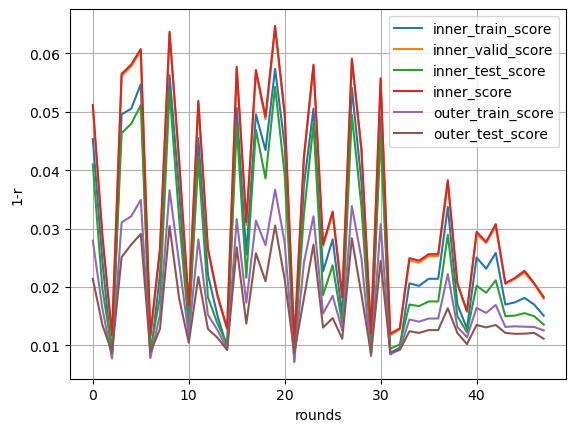

In [8]:
df = study_df

# nanを削除
new_df = df.dropna(how='any',axis=0)
print('{}/{} is COMPLETE'.format(new_df.shape[0],df.shape[0]))

scores_df = new_df['user_attrs']
test_score = scores_df[[x for x in scores_df.columns if x.startswith('test_score')]].mean(axis=1).values
valid_score = scores_df[[x for x in scores_df.columns if x.startswith('valid_score')]].mean(axis=1).values
train_score = scores_df[[x for x in scores_df.columns if x.startswith('train_score')]].mean(axis=1).values

all_valid_score = scores_df['all_valid_score'].values
retrain_score = scores_df['retrain_score'].values
retest_score = scores_df['retest_score'].values



plt.plot(train_score, label='inner_train_score')
plt.plot(valid_score, label='inner_valid_score')
plt.plot(test_score, label='inner_test_score')

plt.plot(all_valid_score, label='inner_score')

plt.plot(retrain_score, label='outer_train_score')
plt.plot(retest_score, label='outer_test_score')



plt.grid()
plt.legend()
# plt.ylim(0, 1.1)

plt.xlabel('rounds')
plt.ylabel('1-r')
plt.show()

In [9]:
scores_df = new_df['user_attrs']
scores_df

,all_valid_score,lightGBM_iter_0,lightGBM_iter_1,lightGBM_iter_2,lightGBM_iter_refit,retest_score,retrain_score,test_score_0,test_score_1,test_score_2,train_score_0,train_score_1,train_score_2,valid_score_0,valid_score_1,valid_score_2
0,0.051163,894,792,869.0,1038.0,0.021366,0.027904,0.040933,0.040255,0.041743,0.044334,0.044640,0.046967,0.053837,0.051831,0.046874
1,0.028802,993,1005,966.0,1069.0,0.013452,0.016251,0.021016,0.018047,0.019951,0.024123,0.022248,0.027088,0.031259,0.030066,0.024032
2,0.011707,1384,1362,1247.0,1321.0,0.008768,0.007744,0.009397,0.008822,0.009187,0.007882,0.007494,0.008121,0.011588,0.012284,0.010670
3,0.056494,877,796,860.0,1024.0,0.025103,0.031040,0.044405,0.046798,0.047881,0.048567,0.048402,0.051663,0.057832,0.057372,0.053207
4,0.058072,988,784,897.0,1073.0,0.027238,0.032091,0.046497,0.048492,0.048818,0.048318,0.050673,0.052570,0.059159,0.059209,0.054978
5,0.060752,923,796,761.0,997.0,0.029087,0.034911,0.051625,0.050474,0.051227,0.052695,0.053032,0.058434,0.063878,0.060270,0.056844
6,0.011687,1418,1321,1305.0,1303.0,0.008777,0.007852,0.009469,0.008910,0.008940,0.007991,0.007815,0.007917,0.011486,0.012590,0.010456
7,0.026521,1135,1002,964.0,1069.0,0.012795,0.015226,0.018677,0.017413,0.018622,0.020834,0.020283,0.025135,0.027345,0.028578,0.022706
8,0.063710,911,792,838.0,937.0,0.030418,0.036566,0.055174,0.053404,0.052067,0.055004,0.055477,0.058314,0.068778,0.063098,0.058169
9,0.041634,833,897,961.0,1033.0,0.018003,0.024028,0.032961,0.031124,0.030843,0.037214,0.034537,0.037388,0.043887,0.043015,0.036815


0.008693701543325938

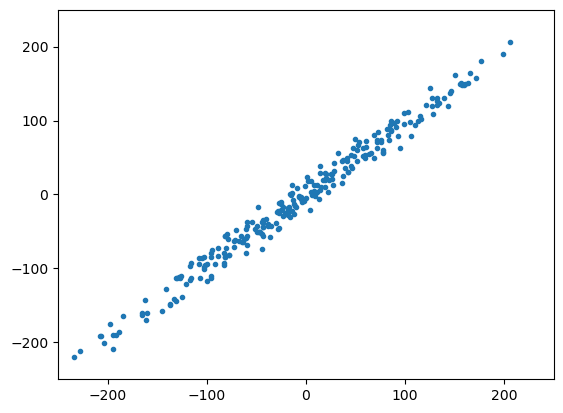

In [10]:
plt.plot(y_test_outer,preds,'.')
plt.xlim(-250,250)
plt.ylim(-250,250)

my_score(y_test_outer,preds)

In [11]:
stop()

NameError: name 'stop' is not defined

In [12]:
study_df

number     value             datetime_start          datetime_complete  \
                                                                            
0       0  0.051163 2025-04-24 18:33:42.157061 2025-04-24 18:35:24.814906   
1       1  0.028802 2025-04-24 18:33:42.157061 2025-04-24 18:35:36.545665   
2       2  0.011707 2025-04-24 18:33:42.158061 2025-04-24 18:36:14.487051   
3       3  0.056494 2025-04-24 18:33:42.159062 2025-04-24 18:35:23.773064   
4       4  0.058072 2025-04-24 18:33:42.159062 2025-04-24 18:35:37.147848   
5       5  0.060752 2025-04-24 18:33:42.160061 2025-04-24 18:35:32.701017   
6       6  0.011687 2025-04-24 18:33:42.161061 2025-04-24 18:36:15.439995   
7       7  0.026521 2025-04-24 18:33:42.162064 2025-04-24 18:35:49.166765   
8       8  0.063710 2025-04-24 18:33:42.163062 2025-04-24 18:35:28.488032   
9       9  0.041634 2025-04-24 18:33:42.165062 2025-04-24 18:35:36.819308   
10     10  0.016784 2025-04-24 18:33:42.166062 2025-04-24 18:36:03.271215   
11     11  0.051867 2025-04-24 18:33:42.172572 2025-04-24 18:35:35.996278   
12     12  0.026521 2025-04-24 18:33:42.174572 2025-04-24 18:35:51.240934   
13     13  0.018569 2025-04-24 18:33:42.175571 2025-04-24 18:35:58.539126   
14     14  0.012901 2025-04-24 18:33:42.180571 2025-04-24 18:36:08.910525   
15     15  0.057706 2025-04-24 18:33:42.182571 2025-04-24 18:35:34.917411   
16     16  0.031096 2025-04-24 18:33:42.183571 2025-04-24 18:35:50.799951   
17     17  0.057159 2025-04-24 18:33:42.185571 2025-04-24 18:35:36.030278   
18     18  0.049145 2025-04-24 18:33:42.186571 2025-04-24 18:35:32.211069   
19     19  0.064705 2025-04-24 18:33:42.187571 2025-04-24 18:35:28.850365   
20     20  0.049697 2025-04-24 18:33:42.188571 2025-04-24 18:35:29.243341   
21     21  0.010623 2025-04-24 18:33:42.190571 2025-04-24 18:36:17.274508   
22     22  0.042245 2025-04-24 18:33:42.199572 2025-04-24 18:35:35.346788   
23     23  0.058072 2025-04-24 18:33:42.217572 2025-04-24 18:35:36.744794   
24     24  0.027270 2025-04-24 18:33:42.242573 2025-04-24 18:35:48.430329   
25     25  0.032921 2025-04-24 18:33:42.284087 2025-04-24 18:35:42.614210   
26     26  0.018259 2025-04-24 18:33:42.325088 2025-04-24 18:35:54.841348   
27     27  0.059109 2025-04-24 18:33:42.333090 2025-04-24 18:35:27.381634   
28     28  0.043635 2025-04-24 18:33:42.339087 2025-04-24 18:35:37.257074   
29     29  0.012038 2025-04-24 18:33:42.341088 2025-04-24 18:36:13.022449   
30     30  0.055740 2025-04-24 18:33:42.342090 2025-04-24 18:35:27.550933   
31     31  0.011973 2025-04-24 18:33:42.342090 2025-04-24 18:36:13.027450   
32     32  0.012901 2025-04-24 18:35:23.784064 2025-04-24 18:36:55.363644   
33     33  0.024927 2025-04-24 18:35:24.852914 2025-04-24 18:36:51.550025   
34     34  0.024482 2025-04-24 18:35:27.393633 2025-04-24 18:36:52.197640   
35     35  0.047181 2025-04-24 18:35:27.569137 2025-04-24 18:36:14.300916   
36     36  0.025601 2025-04-24 18:35:28.519031 2025-04-24 18:36:51.317410   
37     37  0.025601 2025-04-24 18:35:28.859364 2025-04-24 18:36:50.736449   
38     38  0.038273 2025-04-24 18:35:29.250345 2025-04-24 18:36:46.757726   
39     39  0.020636 2025-04-24 18:35:32.217068 2025-04-24 18:36:52.643097   
40     40  0.042245 2025-04-24 18:35:32.704016 2025-04-24 18:36:29.186674   
41     41  0.015838 2025-04-24 18:35:34.927409 2025-04-24 18:36:55.309134   
42     42  0.029423 2025-04-24 18:35:35.355794 2025-04-24 18:36:52.088587   
43     43  0.027728 2025-04-24 18:35:36.008281 2025-04-24 18:36:54.309956   
44     44  0.030752 2025-04-24 18:35:36.043281 2025-04-24 18:36:52.340671   
45     45  0.020636 2025-04-24 18:35:36.591698 2025-04-24 18:36:54.106706   
46     46  0.021532 2025-04-24 18:35:36.756799 2025-04-24 18:36:54.338470   
47     47  0.022767 2025-04-24 18:35:36.831308 2025-04-24 18:36:55.066425   
48     48  0.020636 2025-04-24 18:35:37.154852 2025-04-24 18:36:54.450982   
49     49  0.018259 2025-04-24 18:35:37.261070 2025-04-24 18:36:54.803140   

In [ ]:
import pyopencl as cl

# 全てのプラットフォームを取得
platforms = cl.get_platforms()

# 各プラットフォームの詳細を表示
for platform_id, platform in enumerate(platforms):
    print(f"Platform ID: {platform_id}, Name: {platform.name}")
    # 各プラットフォーム内のデバイスを取得
    devices = platform.get_devices()
    for device_id, device in enumerate(devices):
        print(f"  Device ID: {device_id}, Name: {device.name}, Type: {cl.device_type.to_string(device.type)}")

In [ ]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    'random_state': 0,        # default = None
    "verbose": -1,
}
num_round = 100

lgb_train = lgb.Dataset(X_train_outer, y_train_outer)
lgb_eval = lgb.Dataset(X_test_outer,y_test_outer, reference=lgb_train)

# training
model = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                
                # early_stopping_rounds=50
               )


# prediction
pred = model.predict(X_test_outer, num_iteration=model.best_iteration)


plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='test rmse')
plt.grid()
plt.legend()
# plt.ylim(0, 1.1)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

scores = calculate_scores(y_test_outer,pred)
print(scores)

In [ ]:
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mean_squared_error',
    'metric': 'mae',
    "verbosity": -1,
    "boosting_type": "gbdt",
}
num_round = 100

lgb_train = lgb.Dataset(X_train_outer, y_train_outer)
lgb_eval = lgb.Dataset(X_test_outer,y_test_outer, reference=lgb_train)

best_params, history = {}, []

# LightGBM学習
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=[lgb_train, lgb_eval],
                feature_name = []
                # early_stopping_rounds=50
               )

best_params = gbm.params

# LightGBM推論
y_pred = gbm.predict(X_test_outer, num_iteration=gbm.best_iteration)

scores = calculate_scores(y_test_outer,pred)
print(scores)


In [ ]:
print(X_train_outer.shape, y_train_outer.shape, sub_train_outer.shape)

In [ ]:


# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
}

print("Starting training...")
# train
gbm = lgb.train(
    params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=5)]
)


In [ ]:
# %% 手順3＆4) パラメータ選択＆クロスバリデーション（optunaでベイズ最適化）
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 10)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X_cv, y_cv, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

# %% 学習曲線のプロット
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
model.set_params(**best_params)

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=model,
                                                         X=X_cv, y=y_cv,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

In [ ]:
np.array(sub_list).reshape(-1)

In [ ]:
plt.hist(Y)